In [1]:
%matplotlib notebook
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import glob

sys.path.append("../../../libs/")
#import HEq
import MosaicFitsReader as mfr

In [10]:
 def centroid(arr):
    """
    One step 1D centroiding algo.
    Returns centroid position and standard deviation
    """
    l = arr.shape[0]
    ixs = np.arange(l)
    arr = arr - np.median(arr)
    arr = np.where(arr < 0, 0, arr)    
    ixs2 = ixs * ixs
    sumarr = arr.sum()
    cen = np.dot(arr, ixs)/sumarr
    return cen, math.sqrt(np.dot(arr, ixs2)/sumarr - cen * cen)

def centroidLoop(arr, fromIdx, toIdx, nLoops=10, epsilon=1E-1):
    """
    Finds the centroid by repeatedly centering and recalculating 
    until the centroid position changes by less than epsilon.
    
    Returns status, centroid position, standard deviation, iterations
    
    status: 0 OK, -1 bad centroid or no signal
    centroid position: position relative to input array, ie. 0 is first pixel
    standard deviation: standard deviation as calculated by the centroid algorithm (assumed Gaussian stats)
    iterations: number of iterations needed until change is less than epsilon
    """
    def limit(x):
        if x < 0: return 0
        if x >= length: return length
        return x
    
    length = len(arr)
    radius = (toIdx - fromIdx)/2
    lastCenPos = -9999
    for i in range(nLoops):
        fromIdx = int(limit(fromIdx))
        toIdx = int(limit(fromIdx + radius + radius + 0.5))
        pos, cenStd = centroid(arr[fromIdx:toIdx])
        cenPos = pos + fromIdx
        #print (i, fromIdx, toIdx, cenPos, cenStd, lastCenPos)
        
        if cenPos < fromIdx or toIdx < cenPos:
            return -1, 0, 0, i
        
        if abs(lastCenPos - cenPos) < epsilon:
            return 0, cenPos, cenStd, i
        if cenStd > radius/3:
            return -1, cenPos, cenStd, i
        fromIdx = cenPos - radius
        lastCenPos = cenPos
        
    return -1, cenPos, cenStd, i  

In [17]:
def findWidths (arr1d, size=60):
    """
    Divides the input array in segments of size length.
    For each segment, finds the centroid, if centroid is good then record it.
    Sorts the centroids by standard deviation.
    Returns the smallest half of the standard deviation
    """
    out = []
    for x in range(0, len(arr1d)-size, size):
        ok, cen, std, idx = centroidLoop(arr1d, x, x+size)     
        #print (res)
        if ok == 0:
            out.append(std)
    #print (out)
    if len(out) <= 0:
        return []
    out = sorted(out)
    return out[:len(out)//2]

In [5]:
def makePairs(data):
    """
    Input data is in the format: ((focus1, (v1, v2, v3...)), (focus2, (v1, v2, v3)))
    
    Outputs the focus and std as pairs: ((focus1, v1), (focus1, v2), ....)
    """
    for a, b in data:
        for c in b:
            yield (a, c)
            
def calcAsymptote(A, B, C):
    """
    y^2 = Ax^2 + Bx + C
    
    Returns the parameters for the asymptotes for given A, B, C
    """
    h = -B/A/2
    a2 = C - A * h*h
    b2 = a2/A
    m0 = math.sqrt(a2/b2)
    b0 = -m0 * h
    return m0, b0, h

def asympFunc(m, b):
    """
    Returns a function to calculate the asymptote y for given x.
    """
    def f(x):
        return m * x + b
    return f

In [20]:
"""
For all input files, finds the standard deviations of the centroids.
These standard deviations are assosicated with the focus. 

Output is stored in out[].
"""

out = []
for f in range(8, 15):
    fname = "bfoc%04d.fits" % f
    ffile = mfr.MosaicFitsReader(fname)
    img = ffile.data
    blueFocus = ffile.getKeyword('BLUFOCUS')
    if blueFocus == None:
        continue
    cut1d = img[:,1800]
    widths = findWidths(cut1d)
    out.append((blueFocus, widths))


In [21]:
"""
Prepared values for display and for fitting
"""
pairs = np.array(list(makePairs(out))).T

In [22]:
"""
Fits a hyperbola: x=focus, y=standard deviation

Hyperbola equation: y^2 = Ax^2 + Bx + C

"""
res = np.polyfit(pairs[0], np.multiply(pairs[1], pairs[1]), deg=2)

func = np.poly1d(res)
def func1 (x):
    return math.sqrt(func(x))

funcV = np.vectorize(func1)

"""
Finds the parameters for the asymptotes
"""
A, B, C = res
m0, b0, minX = calcAsymptote(A, B, C)
print ("minX", minX, "Asymp", m0, b0)

minX -3509.03016741 Asymp 0.009697661831131528 34.0293879187


<IPython.core.display.Javascript object>


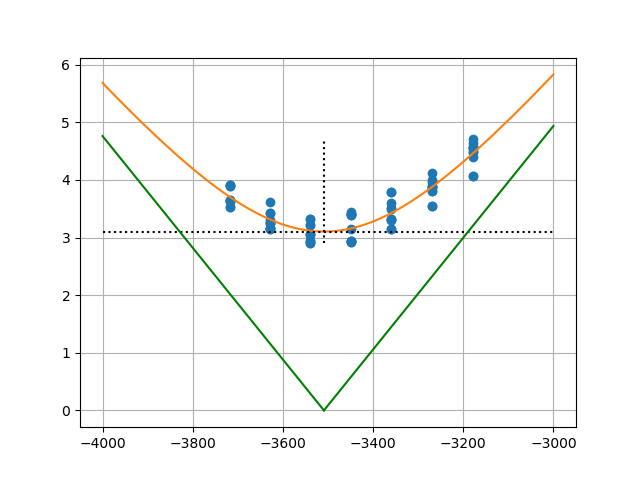

In [24]:
"""
Plots the (focus, std) pairs
"""
plt.plot(pairs[0], pairs[1], 'o')
x0, x1 = -4000, -3000 # min(pairs[0]), max(pairs[0])

"""
Plots the fitted hyperbola
"""
xs = np.linspace(x0, x1, 100)
plt.plot(xs, funcV(xs))

"""
Plots a vertical line at best focus and a horizontal line at best focus
"""
plt.plot((x0, x1), (funcV(minX), funcV(minX)), 'k:')
plt.plot((minX, minX), (min(pairs[1]), max(pairs[1])), 'k:')

"""
Plots the asymptotes
"""
posAsymp = asympFunc(m0, b0)
negAsymp = asympFunc(-m0, -b0)

plt.plot((x0, minX), (negAsymp(x0), negAsymp(minX)), 'g-')
plt.plot((minX, x1), (posAsymp(minX), posAsymp(x1)), 'g-')
plt.grid()